In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from GenerateInput import generate_input
from LifeStepFunctions import life_step_for_tensors
from 

In [2]:
# creating input for the 3x3 grid model
# the input is all possible 3x3 grids, i.e 2^9=512 grids

x_train = list()
for x in product([0,1], repeat=9):
    x1, x2, x3, x4, x5, x6, x7, x8, x9 = x
    sample = [[x1, x2, x3], [x4, x5, x6], [x7, x8, x9]]
    x_train.append(sample)

x_train = tf.constant(np.array(x_train), dtype='float32')
y_train = life_step_for_tensors(x_train)

In [7]:
# defining the model for the 3x3 grid

model_3x3 = tf.keras.models.Sequential()
model_3x3.add(tf.keras.layers.Flatten())
model_3x3.add(tf.keras.layers.Dense(2, activation='relu'))
model_3x3.add(tf.keras.layers.Dense(6, activation='relu'))
model_3x3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [9]:
# training the 3x3 grid model

model_3x3.compile(loss='mse', optimizer='adam', metrics=["accuracy"])

model_3x3.fit(x_train, y_train, epochs=100, batch_size=5)

Train on 512 samples
Epoch 1/100
512/512 [==============================] - 1s 1ms/sample - loss: 0.0365 - accuracy: 0.9453
Epoch 2/100
512/512 [==============================] - 0s 402us/sample - loss: 0.0351 - accuracy: 0.9531
Epoch 3/100
512/512 [==============================] - 0s 394us/sample - loss: 0.0340 - accuracy: 0.9473
Epoch 4/100
512/512 [==============================] - 0s 381us/sample - loss: 0.0329 - accuracy: 0.9707
Epoch 5/100
512/512 [==============================] - 0s 394us/sample - loss: 0.0315 - accuracy: 0.9766
Epoch 6/100
512/512 [==============================] - 0s 374us/sample - loss: 0.0305 - accuracy: 0.9746
Epoch 7/100
512/512 [==============================] - 0s 406us/sample - loss: 0.0293 - accuracy: 1.0000
Epoch 8/100
512/512 [==============================] - 0s 361us/sample - loss: 0.0283 - accuracy: 1.0000
Epoch 9/100
512/512 [==============================] - 0s 409us/sample - loss: 0.0272 - accuracy: 1.0000
Epoch 10/100
512/512 [==============

&lt;tensorflow.python.keras.callbacks.History at 0x2ab74b940c8&gt;

In [10]:
#checking graphically the model_3x3 has 100% accuracy

# y_pred = (model_3x3.call(x_train) > 0.5)
# y_pred = tf.cast(y_pred, dtype="float32")

# y_pred = tf.reshape(y_pred, shape=(16,32))
# y_train = tf.reshape(y_train, shape=(16,32))

# plt.figure(figsize=(16, 24))
# for i in range(len(y_pred)):
#     plt.subplot(48, 1, i+1 + 2*i)
#     plt.imshow([y_pred[i]])
    
#     plt.subplot(48, 1, i+2+ 2*(i))
    
#     plt.imshow([y_train[i]])

In [11]:
class MyModel1(tf.keras.models.Model):
    def __init__(self, grid_size):
        super(MyModel1, self).__init__()
        self.m = grid_size[0]
        self.n = grid_size[1]

    def build(self, input_shape):
        batch_size = input_shape[0]
        self.grid = tf.Variable(tf.zeros(shape=(batch_size, self.m,self.n)), dtype='float32')

        self.grids_3x3 = NoDependency(dict())
        for i in range(self.m):
            for j in range(self.n):
                self.grids_3x3[(i,j)] = tf.Variable(tf.zeros(shape=(batch_size,3,3)), dtype='float32')


    def call(self, x):
        # find values for the cells in the interior
        for i in range(1,self.m-1):
            for j in range(1,self.n-1):
                #print(self.grids_3x3[(i,j)].shape, i, j)
                #print(x[:,i-1:i+2, j-1:j+2].shape, (i-1,i+2), (j-1,j+2))
                self.grids_3x3[(i,j)].assign(x[:,i-1:i+2, j-1:j+2])
                X = model_3x3.call(self.grids_3x3[(i,j)])
                X = tf.reshape(X, shape=(-1,1,1))
                self.grid[:,i:i+1,j:j+1].assign(X)

        # find values for the boundary cells
        for i in range(1, self.m-1):
            self.grids_3x3[(i,0)][:,:,1:].assign(x[:,i-1:i+2,:2])
            self.grids_3x3[(i,0)][:,:,0:1].assign(x[:,i-1:i+2,-1:])
            
            X = model_3x3.call(self.grids_3x3[(i,0)])
            X = tf.reshape(X, shape=(-1,1,1))
            self.grid[:,i:i+1,0:1].assign(X)
        
        for i in range(1, self.m-1):
            self.grids_3x3[(i,self.n-1)][:,:,:2].assign(x[:,i-1:i+2,-2:])
            self.grids_3x3[(i,self.n-1)][:,:,-1:].assign(x[:,i-1:i+2,0:1])
            
            X = model_3x3.call(self.grids_3x3[(i,self.n-1)])
            X = tf.reshape(X, shape=(-1,1,1))
            self.grid[:,i:i+1,-1:].assign(X)

        for j in range(1, self.n-1):
            self.grids_3x3[(0,j)][:,1:,:].assign(x[:,:2,j-1:j+2])
            self.grids_3x3[(0,j)][:,0:1,:].assign(x[:,-1:,j-1:j+2])
            
            X = model_3x3.call(self.grids_3x3[(0,j)])
            X = tf.reshape(X, shape=(-1,1,1))
            self.grid[:,0:1,j:j+1].assign(X)

        for j in range(1, self.n-1):
            self.grids_3x3[(self.m-1,j)][:,2:,:].assign(x[:,:1,j-1:j+2])
            self.grids_3x3[(self.m-1,j)][:,:2,:].assign(x[:,-2:,j-1:j+2])
            
            X = model_3x3.call(self.grids_3x3[(self.m-1,j)])
            X = tf.reshape(X, shape=(-1,1,1))
            self.grid[:,-1:,j:j+1].assign(X)

        # point (0,0)
        self.grids_3x3[(0,0)][:,1:,1:].assign(x[:,:2,:2])
        self.grids_3x3[(0,0)][:,:1,1:].assign(x[:,-1:,0:2])
        self.grids_3x3[(0,0)][:,1:,:1].assign(x[:,:2,-1:])
        self.grids_3x3[(0,0)][:,:1,:1].assign(x[:,-1:,-1:])

        X = model_3x3.call(self.grids_3x3[(0,0)])
        X = tf.reshape(X, shape=(-1,1,1))
        self.grid[:,0:1,0:1].assign(X)

        # point (0,-1)
        self.grids_3x3[(0,self.n-1)][:,1:,:2].assign(x[:,:2,-2:])
        self.grids_3x3[(0,self.n-1)][:,:1,:2].assign(x[:,-1:,-2:])
        self.grids_3x3[(0,self.n-1)][:,1:,-1:].assign(x[:,:2,:1])
        self.grids_3x3[(0,self.n-1)][:,:1,-1:].assign(x[:,-1:,0:1])
        
        X = model_3x3.call(self.grids_3x3[(0,self.n-1)])
        X = tf.reshape(X, shape=(-1,1,1))
        self.grid[:,:1,-1:].assign(X)

        # point (-1, 0)
        self.grids_3x3[(self.m-1,0)][:,:2,-2:].assign(x[:,-2:,:2])
        self.grids_3x3[(self.m-1,0)][:,:2,:1].assign(x[:,-2:,-1:])
        self.grids_3x3[(self.m-1,0)][:,2:,-2:].assign(x[:,:1,:2])
        self.grids_3x3[(self.m-1,0)][:,-1:,:1].assign(x[:,:1,-1:])
        
        X = model_3x3.call(self.grids_3x3[(self.m-1,0)])
        X = tf.reshape(X, shape=(-1,1,1))
        self.grid[:,-1:,:1].assign(X)

        # point (-1,-1)
        self.grids_3x3[(self.m-1,self.n-1)][:,:2,:2].assign(x[:,-2:,-2:])
        self.grids_3x3[(self.m-1,self.n-1)][:,:2,-1:].assign(x[:,-2:,:1])
        self.grids_3x3[(self.m-1,self.n-1)][:,-1:,:2].assign(x[:,:1,-2:])
        self.grids_3x3[(self.m-1,self.n-1)][:,-1:,-1:].assign(x[:,:1,:1])
        
        X = model_3x3.call(self.grids_3x3[(self.m-1,self.n-1)])
        X = tf.reshape(X, shape=(-1,1,1))
        self.grid[:,-1:,-1:].assign(X)
        return self.grid

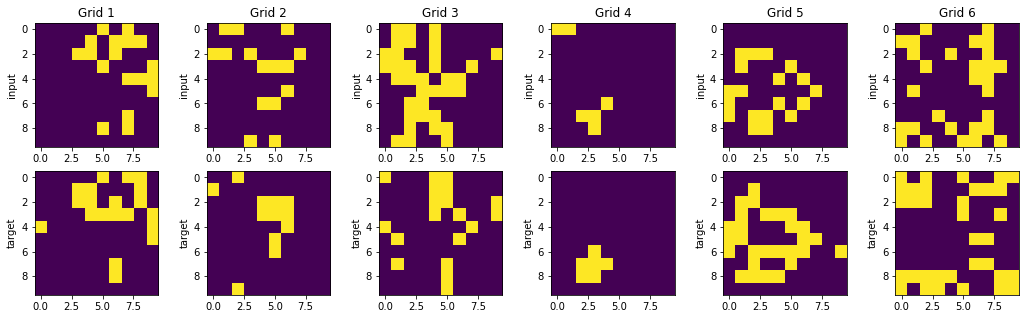

In [12]:
# generating some inputs and targets for the general mode

x, y = generate_input(trials=8, grid_shape=(10,10),steps_before_generating_output=2)


plt.figure(figsize=(3*len(x), 5))
for i in range(len(x)):
    plt.subplot(2, len(x), i+1)
    plt.title('Grid ' + str(i+1))
    plt.imshow(x[i])
    plt.ylabel('input')
    plt.subplot(2, len(x), len(x)+i+1)
    plt.imshow(y[i])
    plt.ylabel('target')
    

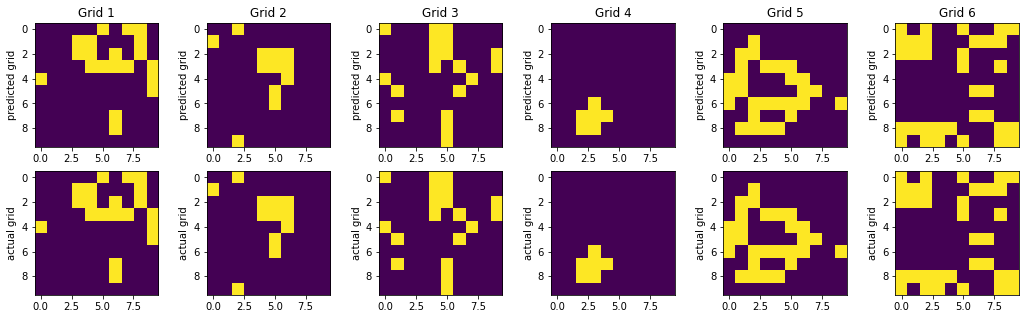

In [13]:

# checking that the general model actually works
game = MyModel1(grid_size=(10,10))

inputs = tf.keras.layers.Input(shape=(10,10), batch_size=len(x))
game(inputs)

y_pred = game.predict(x)

y_pred = tf.constant(y_pred)
y_pred = (y_pred > 0.5)
y__pred = tf.cast(y_pred, dtype="float32")

plt.figure(figsize=(3*len(x), 5))
for i in range(len(y)):
    plt.subplot(2, len(y), i+1)
    plt.title('Grid ' + str(i+1))
    plt.imshow(y_pred[i])
    plt.ylabel('predicted grid')
    plt.subplot(2, len(y), len(y)+i+1)
    plt.imshow(y[i])
    plt.ylabel('actual grid')

In [14]:
game_1_sample = MyModel1(grid_size=(10,10))
inputs = tf.keras.layers.Input(shape=(10,10), batch_size=1)
game_1_sample(inputs)

def compute_loss(input_img, target_img):
    output_img = game_1_sample(input_img)
    
    return tf.reduce_mean(output_img, target_img)

def initialize_image(grid_size=(10,10)):
    # We start from a gray image   # maybe I should add some random noise
    img = tf.random.uniform((1, grid_size[0], grid_size[1]))
    return img

In [18]:
opt = tf.keras.optimizers.Adam()

loss = compute_loss(img, target_img)
# Compute gradients.
grads = opt.minimize(loss, img)
    

NotFoundError: Could not find valid device for node.
Node:{{node Mean}}
All kernels registered for op Mean :
  device=&#39;CPU&#39;; T in [DT_INT64]; Tidx in [DT_INT32]
  device=&#39;CPU&#39;; T in [DT_INT64]; Tidx in [DT_INT64]
  device=&#39;CPU&#39;; T in [DT_INT32]; Tidx in [DT_INT32]
  device=&#39;CPU&#39;; T in [DT_INT32]; Tidx in [DT_INT64]
  device=&#39;CPU&#39;; T in [DT_UINT16]; Tidx in [DT_INT32]
  device=&#39;CPU&#39;; T in [DT_UINT16]; Tidx in [DT_INT64]
  device=&#39;CPU&#39;; T in [DT_INT16]; Tidx in [DT_INT32]
  device=&#39;CPU&#39;; T in [DT_INT16]; Tidx in [DT_INT64]
  device=&#39;CPU&#39;; T in [DT_UINT8]; Tidx in [DT_INT32]
  device=&#39;CPU&#39;; T in [DT_UINT8]; Tidx in [DT_INT64]
  device=&#39;CPU&#39;; T in [DT_INT8]; Tidx in [DT_INT32]
  device=&#39;CPU&#39;; T in [DT_INT8]; Tidx in [DT_INT64]
  device=&#39;CPU&#39;; T in [DT_HALF]; Tidx in [DT_INT32]
  device=&#39;CPU&#39;; T in [DT_HALF]; Tidx in [DT_INT64]
  device=&#39;CPU&#39;; T in [DT_BFLOAT16]; Tidx in [DT_INT32]
  device=&#39;CPU&#39;; T in [DT_BFLOAT16]; Tidx in [DT_INT64]
  device=&#39;CPU&#39;; T in [DT_FLOAT]; Tidx in [DT_INT32]
  device=&#39;CPU&#39;; T in [DT_FLOAT]; Tidx in [DT_INT64]
  device=&#39;CPU&#39;; T in [DT_DOUBLE]; Tidx in [DT_INT32]
  device=&#39;CPU&#39;; T in [DT_DOUBLE]; Tidx in [DT_INT64]
  device=&#39;CPU&#39;; T in [DT_COMPLEX64]; Tidx in [DT_INT32]
  device=&#39;CPU&#39;; T in [DT_COMPLEX64]; Tidx in [DT_INT64]
  device=&#39;CPU&#39;; T in [DT_COMPLEX128]; Tidx in [DT_INT32]
  device=&#39;CPU&#39;; T in [DT_COMPLEX128]; Tidx in [DT_INT64]
 [Op:Mean]

In [44]:
# We run gradient ascent for 20 steps
iterations = 30
learning_rate = 0.1
img = initialize_image()
for iteration in range(iterations):
    print(iteration)
    loss, img = gradient_ascent_step(img, y[0], learning_rate)



0


ValueError: in converted code:

    &lt;ipython-input-37-62e97c685e25&gt;:9 gradient_ascent_step  *
        grads = tf.math.l2_normalize(grads)
    C:\Users\Lisa\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow_core\python\ops\nn_impl.py:650 l2_normalize_v2
        x = ops.convert_to_tensor(x, name=&quot;x&quot;)
    C:\Users\Lisa\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow_core\python\framework\ops.py:1184 convert_to_tensor
        return convert_to_tensor_v2(value, dtype, preferred_dtype, name)
    C:\Users\Lisa\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow_core\python\framework\ops.py:1242 convert_to_tensor_v2
        as_ref=False)
    C:\Users\Lisa\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow_core\python\framework\ops.py:1296 internal_convert_to_tensor
        ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
    C:\Users\Lisa\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow_core\python\framework\constant_op.py:286 _constant_tensor_conversion_function
        return constant(v, dtype=dtype, name=name)
    C:\Users\Lisa\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow_core\python\framework\constant_op.py:227 constant
        allow_broadcast=True)
    C:\Users\Lisa\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow_core\python\framework\constant_op.py:265 _constant_impl
        allow_broadcast=allow_broadcast))
    C:\Users\Lisa\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow_core\python\framework\tensor_util.py:437 make_tensor_proto
        raise ValueError(&quot;None values not supported.&quot;)

    ValueError: None values not supported.


In [17]:
img = initialize_image()
target_img = y[0]

with tf.GradientTape() as tape:
    tape.watch(img)
    loss = compute_loss(img, target_img)


NotFoundError: Could not find valid device for node.
Node:{{node Mean}}
All kernels registered for op Mean :
  device=&#39;CPU&#39;; T in [DT_INT64]; Tidx in [DT_INT32]
  device=&#39;CPU&#39;; T in [DT_INT64]; Tidx in [DT_INT64]
  device=&#39;CPU&#39;; T in [DT_INT32]; Tidx in [DT_INT32]
  device=&#39;CPU&#39;; T in [DT_INT32]; Tidx in [DT_INT64]
  device=&#39;CPU&#39;; T in [DT_UINT16]; Tidx in [DT_INT32]
  device=&#39;CPU&#39;; T in [DT_UINT16]; Tidx in [DT_INT64]
  device=&#39;CPU&#39;; T in [DT_INT16]; Tidx in [DT_INT32]
  device=&#39;CPU&#39;; T in [DT_INT16]; Tidx in [DT_INT64]
  device=&#39;CPU&#39;; T in [DT_UINT8]; Tidx in [DT_INT32]
  device=&#39;CPU&#39;; T in [DT_UINT8]; Tidx in [DT_INT64]
  device=&#39;CPU&#39;; T in [DT_INT8]; Tidx in [DT_INT32]
  device=&#39;CPU&#39;; T in [DT_INT8]; Tidx in [DT_INT64]
  device=&#39;CPU&#39;; T in [DT_HALF]; Tidx in [DT_INT32]
  device=&#39;CPU&#39;; T in [DT_HALF]; Tidx in [DT_INT64]
  device=&#39;CPU&#39;; T in [DT_BFLOAT16]; Tidx in [DT_INT32]
  device=&#39;CPU&#39;; T in [DT_BFLOAT16]; Tidx in [DT_INT64]
  device=&#39;CPU&#39;; T in [DT_FLOAT]; Tidx in [DT_INT32]
  device=&#39;CPU&#39;; T in [DT_FLOAT]; Tidx in [DT_INT64]
  device=&#39;CPU&#39;; T in [DT_DOUBLE]; Tidx in [DT_INT32]
  device=&#39;CPU&#39;; T in [DT_DOUBLE]; Tidx in [DT_INT64]
  device=&#39;CPU&#39;; T in [DT_COMPLEX64]; Tidx in [DT_INT32]
  device=&#39;CPU&#39;; T in [DT_COMPLEX64]; Tidx in [DT_INT64]
  device=&#39;CPU&#39;; T in [DT_COMPLEX128]; Tidx in [DT_INT32]
  device=&#39;CPU&#39;; T in [DT_COMPLEX128]; Tidx in [DT_INT64]
 [Op:Mean]

In [56]:
# Compute gradients.
grads = tape.gradient(loss, img)




In [57]:
print(grads)

None


In [ ]:
# Normalize gradients.
grads = tf.math.l2_normalize(grads)
img += learning_rate * grads
